In [1]:
%matplotlib inline
from fastai import *
from fastai.vision import *

In [2]:
!nvidia-smi

Sat Nov  3 05:33:59 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    34W / 300W |     10MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
sz = 128
path = Path('data')
path_img = path/f'train-{sz}'

In [4]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('data/train-128/tiger_102348.png'),
 PosixPath('data/train-128/ceiling_fan_10647.png'),
 PosixPath('data/train-128/violin_126808.png'),
 PosixPath('data/train-128/mailbox_36074.png'),
 PosixPath('data/train-128/mouse_125046.png')]

In [ ]:
pat = r'/([^/]+)_\d+.png$'

In [ ]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, bs=64, ds_tfms=get_transforms(), size=64, test=Path('../test-128'))
data.normalize(imagenet_stats)

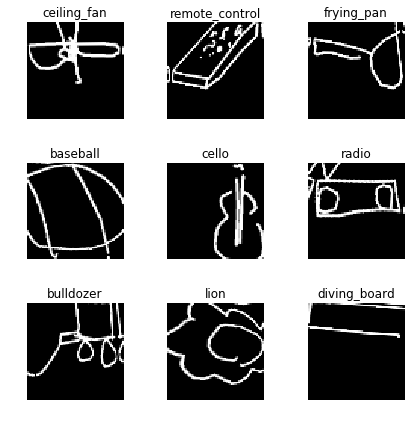

In [ ]:
data.show_batch(rows=3, figsize=(6,6))

In [ ]:
print(data.classes)
len(data.classes),data.c

['tiger', 'ceiling_fan', 'violin', 'mailbox', 'mouse', 'umbrella', 'trombone', 'laptop', 'marker', 'envelope', 'bulldozer', 'flashlight', 'bucket', 'tractor', 'school_bus', 'shoe', 'octopus', 'spreadsheet', 'crab', 'hexagon', 'dolphin', 'cruise_ship', 'dumbbell', 'grapes', 'eyeglasses', 'axe', 'swan', 'pencil', 'swing_set', 'crown', 'shovel', 'crayon', 'police_car', 'underwear', 'suitcase', 'yoga', 'passport', 'leaf', 'bowtie', 'drill', 'church', 'ambulance', 'baseball', 'camera', 'sweater', 'sun', 'table', 'motorbike', 'bathtub', 'alarm_clock', 'golf_club', 'mug', 'speedboat', 'chair', 'raccoon', 'radio', 'scorpion', 'chandelier', 'book', 'sheep', 'pool', 'keyboard', 'lighthouse', 'squirrel', 'house', 'pants', 'paint_can', 'nose', 'zebra', 'boomerang', 'bench', 'mermaid', 'goatee', 'beard', 'power_outlet', 'floor_lamp', 'square', 'helicopter', 'car', 'fireplace', 'moon', 'leg', 'banana', 'dragon', 'zigzag', 'onion', 'squiggle', 'asparagus', 'fan', 'blueberry', 'ladder', 'telephone', '

(340, 340)

## Training: resnet152!!

In [ ]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)#.to_fp16()

In [ ]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate


In [11]:
!nvidia-smi

Sat Nov  3 05:29:48 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    47W / 300W |   2600MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [11]:
learn.save('mystage-152')

## Results

In [12]:
interp = ClassificationInterpretation.from_learner(learn)

In [20]:
#interp.most_confused(min_val=1000)

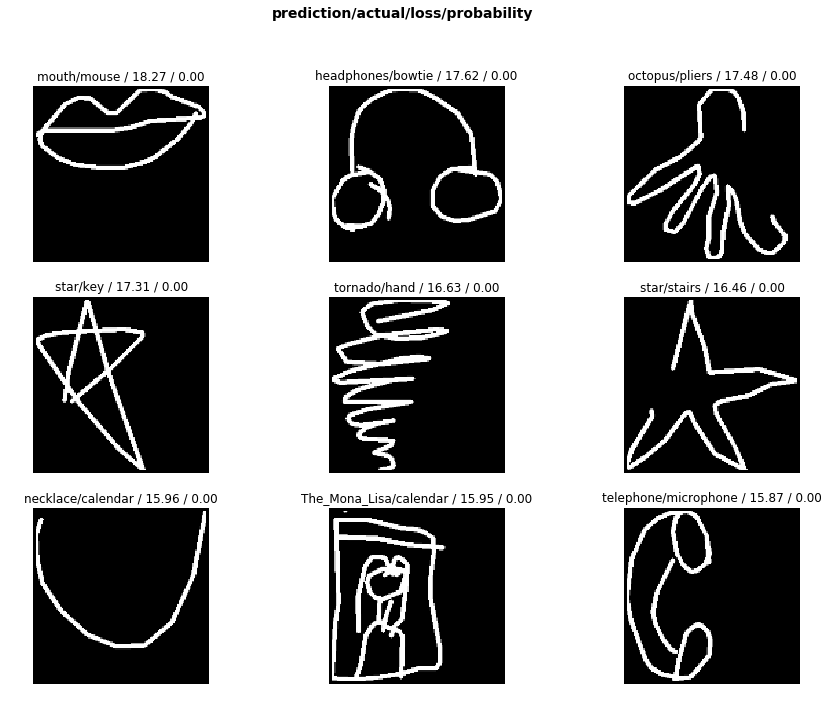

In [21]:
interp.plot_top_losses(9, figsize=(15,11))

## Unfreezing, fine-tuning, and learning rates

In [13]:
learn.load('mystage-152')

In [14]:
learn.unfreeze()

In [15]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


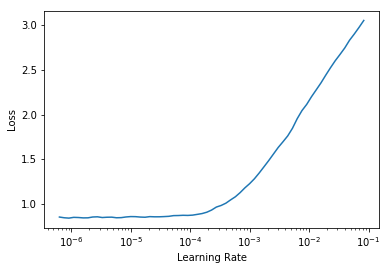

In [16]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(3e-6,3e-3))

epoch,train_loss,valid_loss,error_rate


In [ ]:
learn.save('mystage-2')

## Generate submission

In [ ]:
learn.load('mystage-2')

In [ ]:
preds = learn.TTA(is_test=True)[0]

In [ ]:
top_3 = np.argsort(preds.numpy())[:, ::-1][:, :3]

In [ ]:
n, _ = top_3.shape
labels = []
for i in range(n):
    labels.append(' '.join([learn.data.train_ds.ds.classes[idx] for idx in top_3[i]]))

In [ ]:
learn.data.test_dl.dl.dataset[0][0]

In [ ]:
labels[0]

In [ ]:
key_ids = [path.stem for path in learn.data.test_dl.dl.dataset.x]

In [ ]:
os.makedirs(f'subs', exist_ok=True)

In [ ]:
sub = pd.DataFrame({'key_id': key_ids, 'word': labels})

In [ ]:
sub.head()

In [ ]:
name = 'first_sub_152_simple'

In [ ]:
sub.to_csv(f'subs/{name}.csv.gz', index=False, compression='gzip')

In [ ]:
pd.read_csv(f'subs/{name}.csv.gz').head()

In [37]:
!kaggle competitions submit -c quickdraw-doodle-recognition -f subs/{name}.csv.gz -m "{name}"

/bin/sh: 1: kaggle: not found
